In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from zipfile import ZipFile

MAX_CASES = 2500
MAX_FEATURES = 1000
MAX_EPOCHS = 1000
TEST_RATIO = 0.2

cur = 1
last_action = ""
def counter_message(tot, action):
    global cur, last_action
    
    if last_action != action:
        cur = 1
        last_action = action
    
    print("\r{}/{} {}.".format(cur, tot, action), end=" "*10, flush=True)
    cur += 1

In [2]:
zip_file = ZipFile("cases.zip")
case_ids = []
raw_texts = {}
years = {}

names = zip_file.namelist()
names = [name for name in names if not name.startswith('__MACOSX') and name.endswith('.txt')]

if MAX_CASES is None:
    MAX_CASES = len(names)
    
shuffled_names = np.random.permutation(names)[:MAX_CASES]

for file_name in shuffled_names:
    
    year, case_id = file_name[:-4].split("_")
    
    with zip_file.open(file_name) as file:
        raw_text = file.read().decode()
        
    raw_texts[case_id] = raw_text.lower()
    years[case_id] = int(year)
    
    case_ids.append(case_id)
    
    counter_message(MAX_CASES, "cases opened")

2500/2500 cases opened.                                                                                                                                                                                                                                                                                                                               

In [3]:
import spacy
from stop_words import get_stop_words

stop_words = get_stop_words('english')

nlp = spacy.load("en_core_web_sm")

nlp.remove_pipe("parser")
nlp.remove_pipe("ner")

for w in stop_words:
    nlp.vocab[w].is_stop = True

spacy_docs = {}

for case_id in case_ids:
    spacy_docs[case_id] = nlp(raw_texts[case_id])
    counter_message(MAX_CASES, "cases processed by SpaCy")
    
del raw_texts

2500/2500 cases processed by SpaCy.          

In [4]:
from nltk import ngrams
from collections import Counter
import string

def normalize(token):
    lemma = token.lemma_
    norm_token = lemma.translate(str.maketrans('', '', string.punctuation))
    return norm_token

    

noun_ngrams = {}
total_ngrams = []
word_counts= {}
doc_term_freq = {}

for case_id in case_ids:
    
    tokens = []
    doc_terms = {}
    
    spacy_doc = spacy_docs[case_id]
    
    for token in spacy_doc:
        
        if not token.is_punct and not token.is_space:
            
            tokens.append(token)
            norm_token = normalize(token)
            
            if not norm_token in word_counts:
                word_counts[norm_token] = 1
            else:
                word_counts[norm_token] += 1

    noun_ngram = []
    
    for ngram in ngrams(tokens, 3):
        
        if ngram[2].pos_ == "NOUN":
            
            curr_ngram = (normalize(ngram[0]), normalize(ngram[1]), normalize(ngram[2]))
            noun_ngram.append(curr_ngram)
            total_ngrams.append(curr_ngram)
            
            if not curr_ngram in doc_terms:
                doc_terms[curr_ngram] = 1
        
    noun_ngrams[case_id] = noun_ngram
    counter_message(MAX_CASES, "cases lemmatized")

most_common_terms_by_doc_count = Counter(doc_term_freq).most_common(MAX_FEATURES)


2500/2500 cases lemmatized.                                       

In [5]:
import pandas as pd
import math

outcomes = {}
log_cites = {}
cites = {}
judge_cases = {}
judge_ids = {}

case_metadata = pd.read_csv("data/case_metadata.csv").values
for case_id, outcome, judge_id, year, log_cite in case_metadata:
    
    judge_ids[case_id] = judge_id
    outcomes[case_id] = outcome
    
    if not math.isnan(judge_id):
        
        judge_id = int(judge_id)
        
        try:
            judge_cases[judge_id].append(case_id)
        except:
            judge_cases[judge_id] = []
            judge_cases[judge_id].append(case_id)
            
    if math.isnan(log_cite):
        log_cites[case_id] = 0.0
    else:
        log_cites[case_id] = log_cite

X_raw = []
y_reversed = []
y_log_cites = []
y_cites = []

most_common_features_top = Counter(total_ngrams).most_common(MAX_FEATURES)
most_common_features_filtered = Counter(total_ngrams)

for term in list(most_common_features_filtered):
    if most_common_features_filtered[term] > MAX_CASES / 3:
        del most_common_features_filtered[term]

most_common_features_filtered = most_common_features_filtered.most_common(MAX_FEATURES)
    
for case_id in case_ids:
    
    current_ngram = Counter(noun_ngrams[case_id])
    features = np.zeros(len(most_common_features_filtered))
    for i in range(len(most_common_features_filtered)):
        ngram = most_common_features_filtered[i][0]
        if ngram in current_ngram:
            features[i] = current_ngram[ngram]
    X_raw.append(features)
    y_reversed.append(outcomes[case_id])
    y_log_cites.append(log_cites[case_id])
    counter_message(MAX_CASES, "cases searched for features")

2500/2500 cases searched for features.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [6]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(X_raw)


y_reversed = np.array(y_reversed)
y_log_cites = np.array(y_log_cites)
y_cites = np.array(y_cites)

case_ids = np.array(case_ids)

test_amount = int(X.shape[0]*TEST_RATIO)

permutation = np.random.permutation(X.shape[0])
perm_X = X[permutation]
perm_y_reversed = y_reversed[permutation]
perm_y_log_cites = y_log_cites[permutation]
perm_case_ids = case_ids[permutation]

test_X = perm_X[:test_amount]
test_y_reversed = perm_y_reversed[:test_amount]
test_y_log_cites = perm_y_log_cites[:test_amount]
test_case_ids = perm_case_ids[:test_amount]

train_X = perm_X[test_amount:]
train_y_reversed = perm_y_reversed[test_amount:]
train_y_log_cites = perm_y_log_cites[test_amount:]
train_case_ids = perm_case_ids[test_amount:]

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score, f1_score

log_reg = LogisticRegression(penalty='l2', tol=1e-4, C=0.001, solver='lbfgs', max_iter=1000)#.fit(train_X, train_y_reversed)

y_reversed_pred = cross_val_predict(log_reg, X, y_reversed, cv=5, method='predict')
y_reversed_pred_prob = cross_val_predict(log_reg, X, y_reversed, cv=5, method='predict_proba')
y_reversed_pred_prob = [e[1] for e in y_reversed_pred_prob]

accuracy = accuracy_score(y_reversed, y_reversed_pred)
f1 = f1_score(y_reversed, y_reversed_pred)

conf_matrix = confusion_matrix(y_reversed, y_reversed_pred)

norm_conf_matrix = conf_matrix / conf_matrix.astype(np.float).sum(axis=1)

precision, recall, thresholds_prc = precision_recall_curve(y_reversed, y_reversed_pred_prob)

fpr, tpr, thresholds_roc = roc_curve(y_reversed, y_reversed_pred_prob)

print("accuracy: {:.4f}".format(accuracy))
print("f1 score: {:.4f}".format(f1))

accuracy: 0.6148
f1 score: 0.7521


Text(0.5, 0, 'Predicted label')

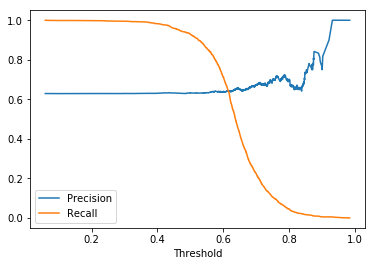

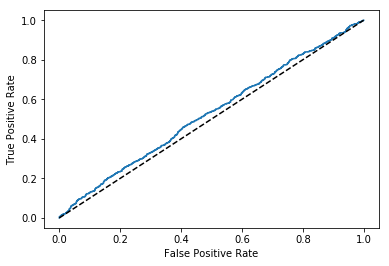

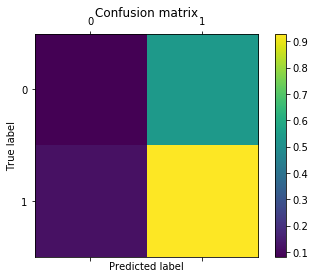

In [9]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(thresholds_prc, precision[:-1], label="Precision")
plt.plot(thresholds_prc, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

plt.figure(1)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.figure(2)
plt.matshow(norm_conf_matrix, fignum=2)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

l1_ration: 0.0
alpha: 10.0


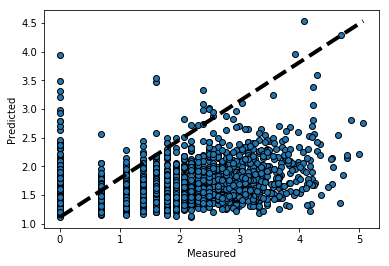

In [10]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

elastic_net = ElasticNetCV(alphas=[.001, .01, .1, 1, 10], l1_ratio=[0,.1,.5,.9,1])
elastic_net.fit(X, y_log_cites)

print("l1_ration: {}".format(elastic_net.l1_ratio_))
print("alpha: {}".format(elastic_net.alpha_)) 

elastic_net = ElasticNet(alpha=elastic_net.alpha_, l1_ratio=elastic_net.l1_ratio_)#.fit(train_X, train_y_log_cites)

y_log_cites_pred = cross_val_predict(elastic_net, X, y_log_cites)

plt.scatter(y_log_cites, y_log_cites_pred, edgecolors=(0, 0, 0))
plt.plot([y_log_cites.min(), y_log_cites.max()], [y_log_cites_pred.min(), y_log_cites_pred.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

In [11]:
from functools import reduce
from operator import add
import pandas as pd
from linearmodels.iv import IV2SLS

avg_judge_cites = {}
for judge_id in judge_cases:
    cites = [10**log_cites[case_id] for case_id in judge_cases[judge_id]]
    avg_judge_cites[judge_id] = np.log(reduce(add,cites))/len(judge_cases[judge_id])

train_avg_judge_cites_by_case = []
for case_id in train_case_ids:
    if not math.isnan(judge_ids[case_id]):
        train_avg_judge_cites_by_case.append(judge_ids[case_id])
    else:
        train_avg_judge_cites_by_case.append(0)
        
test_avg_judge_cites_by_case = []
for case_id in test_case_ids:
    if not math.isnan(judge_ids[case_id]):
        test_avg_judge_cites_by_case.append(judge_ids[case_id])
    else:
        test_avg_judge_cites_by_case.append(0)
    
train_data = {'y_reversed': train_y_reversed, 'z_avg_judge_cites': train_avg_judge_cites_by_case, 'x_log_cites': train_y_log_cites}
train_df = pd.DataFrame.from_dict(train_data)
test_data = {'y_reversed': test_y_reversed, 'z_avg_judge_cites': test_avg_judge_cites_by_case, 'x_log_cites': test_y_log_cites}
test_df = pd.DataFrame.from_dict(test_data)    

formula_iv = 'y_reversed ~ [x_log_cites ~ z_avg_judge_cites]'
iv = IV2SLS.from_formula(formula_iv, data=train_df)
results = iv.fit()
print(results)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             y_reversed   R-squared:                      0.2883
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2880
No. Observations:                2000   F-statistic:                    1173.8
Date:                Wed, Apr 17 2019   P-value (F-stat)                0.0000
Time:                        22:34:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
x_log_cites     0.3266     0.0095     34.261     0.0000      0.3079      0.3452

Endogenous: x_log_cites
Instruments: z_avg_judg

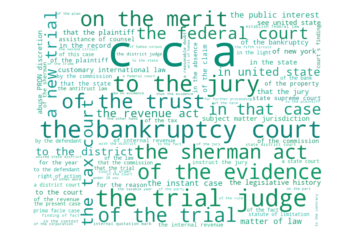

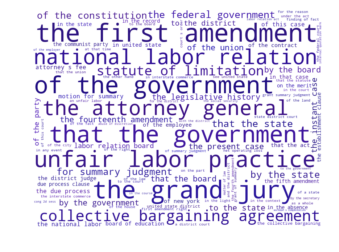

In [12]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud
from os import mkdir
from numpy.random import randint

NUM_TOPICS = 2

documents = []
for case_id in noun_ngrams:
    doc = []
    ngrams = noun_ngrams[case_id]
    for ngram in ngrams:
        term = ngram[0] + " " + ngram[1] + " " + ngram[2]
        doc.append(term)
    documents.append(doc)

#documents = [[token.lemma_ for token in spacy_docs[case_id] if not token.is_stop and not token.is_punct and not token.is_space] for case_id in spacy_docs]  
    
dic = [[term[0][0] + " " + term[0][1] + " " + term[0][2] for term in most_common_features_filtered]]
dictionary = corpora.Dictionary(dic)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in documents]


lda = LdaModel(doc_term_matrix, num_topics=NUM_TOPICS, id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

for i,weights in lda.show_topics(num_topics=-1, num_words=100, formatted=False):
    
    #logweights = [[w[0], np.log(w[1])] for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", ranks_only=False, max_font_size=120, color_func=colorfunc, height=600,width=800).generate_from_frequencies(dict(weights))
    plt.figure(i)
    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")

In [13]:
from keras import Sequential, optimizers, losses, activations
from keras.layers import Dense, Activation
from keras.regularizers import L1L2, l2

model = Sequential()
model.add(Dense(2, activation='softmax', kernel_regularizer=L1L2(l1=0, l2=0.001), input_dim=MAX_FEATURES))

sgd = optimizers.SGD(lr=0.001, momentum=0.5, decay=0.1, nesterov=False)
adam = optimizers.Adam()

test_y_reversed_class = np.array([[1-ty,ty] for ty in test_y_reversed])
train_y_reversed_class = np.array([[1-ty,ty] for ty in train_y_reversed])


model.compile(optimizer=adam, loss=losses.binary_crossentropy, metrics=['accuracy'])
model.fit(train_X, train_y_reversed_class, epochs=MAX_EPOCHS, validation_data=(test_X, test_y_reversed_class), verbose=1, batch_size=100)
#model.fit(train_X, [[1 - ty, ty] for ty in train_y_reversed], epochs=100, validation_data=(test_X, [[1 - ty, ty] for ty in test_y_reversed]), verbose=1, batch_size=50)


print(model.summary())
print("acc: {}".format(model.evaluate(test_X, test_y_reversed_class)[1]))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 500 samples
Epoch 1/1000
2000/2000 [==============================] - 0s 116us/step - loss: 0.9567 - acc: 0.5365 - val_loss: 1.0019 - val_acc: 0.5440
Epoch 2/1000
2000/2000 [==============================] - 0s 22us/step - loss: 0.8063 - acc: 0.5725 - val_loss: 0.9649 - val_acc: 0.5300
Epoch 3/1000
2000/2000 [==============================] - 0s 24us/step - loss: 0.7122 - acc: 0.6115 - val_loss: 0.9435 - val_acc: 0.5380
Epoch 4/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.6453 - acc: 0.6435 - val_loss: 0.9212 - val_acc: 0.5740
Epoch 5/1000
2000/2000 [==============================] - 0s 20us/step - loss: 0.5979 - acc: 0.6710 - val_loss: 0.9112 - val_acc: 0.5520
Epoch 6/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.5629 - acc: 0.6945 - val_loss: 0.9052 - val_acc: 0.5540
Epoch 7/10

2000/2000 [==============================] - 0s 16us/step - loss: 0.3107 - acc: 0.8760 - val_loss: 1.7554 - val_acc: 0.5160
Epoch 115/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.3106 - acc: 0.8805 - val_loss: 1.7625 - val_acc: 0.5180
Epoch 116/1000
2000/2000 [==============================] - 0s 13us/step - loss: 0.3095 - acc: 0.8780 - val_loss: 1.7683 - val_acc: 0.5200
Epoch 117/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.3096 - acc: 0.8780 - val_loss: 1.7701 - val_acc: 0.5180
Epoch 118/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.3102 - acc: 0.8785 - val_loss: 1.7796 - val_acc: 0.5180
Epoch 119/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.3093 - acc: 0.8780 - val_loss: 1.7841 - val_acc: 0.5200
Epoch 120/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.3087 - acc: 0.8805 - val_loss: 1.7940 - val_acc: 0.5160
Epoch 121/1000
2000/2000 [================

2000/2000 [==============================] - 0s 23us/step - loss: 0.2983 - acc: 0.8875 - val_loss: 2.0274 - val_acc: 0.5240
Epoch 174/1000
2000/2000 [==============================] - 0s 22us/step - loss: 0.2987 - acc: 0.8900 - val_loss: 2.0300 - val_acc: 0.5220
Epoch 175/1000
2000/2000 [==============================] - 0s 25us/step - loss: 0.2980 - acc: 0.8885 - val_loss: 2.0355 - val_acc: 0.5220
Epoch 176/1000
2000/2000 [==============================] - 0s 29us/step - loss: 0.2983 - acc: 0.8850 - val_loss: 2.0369 - val_acc: 0.5220
Epoch 177/1000
2000/2000 [==============================] - 0s 39us/step - loss: 0.2990 - acc: 0.8910 - val_loss: 2.0371 - val_acc: 0.5240
Epoch 178/1000
2000/2000 [==============================] - 0s 43us/step - loss: 0.2989 - acc: 0.8815 - val_loss: 2.0482 - val_acc: 0.5160
Epoch 179/1000
2000/2000 [==============================] - 0s 43us/step - loss: 0.2988 - acc: 0.8850 - val_loss: 2.0496 - val_acc: 0.5240
Epoch 180/1000
2000/2000 [================

2000/2000 [==============================] - 0s 15us/step - loss: 0.2936 - acc: 0.8955 - val_loss: 2.2018 - val_acc: 0.5140
Epoch 233/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2931 - acc: 0.8915 - val_loss: 2.2040 - val_acc: 0.5080
Epoch 234/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2932 - acc: 0.8940 - val_loss: 2.2042 - val_acc: 0.5080
Epoch 235/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2925 - acc: 0.8945 - val_loss: 2.2112 - val_acc: 0.5100
Epoch 236/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2928 - acc: 0.8925 - val_loss: 2.2070 - val_acc: 0.5100
Epoch 237/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2928 - acc: 0.8940 - val_loss: 2.2157 - val_acc: 0.5100
Epoch 238/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2926 - acc: 0.8970 - val_loss: 2.2143 - val_acc: 0.5120
Epoch 239/1000
2000/2000 [================

2000/2000 [==============================] - 0s 20us/step - loss: 0.2905 - acc: 0.8940 - val_loss: 2.3221 - val_acc: 0.5040
Epoch 292/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2907 - acc: 0.8955 - val_loss: 2.3144 - val_acc: 0.5140
Epoch 293/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2911 - acc: 0.8970 - val_loss: 2.3175 - val_acc: 0.5080
Epoch 294/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2911 - acc: 0.8975 - val_loss: 2.3172 - val_acc: 0.5140
Epoch 295/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2903 - acc: 0.8970 - val_loss: 2.3196 - val_acc: 0.5120
Epoch 296/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2906 - acc: 0.8965 - val_loss: 2.3263 - val_acc: 0.5080
Epoch 297/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2903 - acc: 0.8965 - val_loss: 2.3237 - val_acc: 0.5120
Epoch 298/1000
2000/2000 [================

2000/2000 [==============================] - 0s 16us/step - loss: 0.2892 - acc: 0.9005 - val_loss: 2.4004 - val_acc: 0.5100
Epoch 351/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2893 - acc: 0.8995 - val_loss: 2.4007 - val_acc: 0.5100
Epoch 352/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2889 - acc: 0.8975 - val_loss: 2.4002 - val_acc: 0.5120
Epoch 353/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2897 - acc: 0.8995 - val_loss: 2.3991 - val_acc: 0.5120
Epoch 354/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2891 - acc: 0.8990 - val_loss: 2.4049 - val_acc: 0.5060
Epoch 355/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2894 - acc: 0.8990 - val_loss: 2.4015 - val_acc: 0.5080
Epoch 356/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2899 - acc: 0.8990 - val_loss: 2.4017 - val_acc: 0.5140
Epoch 357/1000
2000/2000 [================

2000/2000 [==============================] - 0s 17us/step - loss: 0.2883 - acc: 0.9005 - val_loss: 2.4583 - val_acc: 0.5080
Epoch 410/1000
2000/2000 [==============================] - 0s 18us/step - loss: 0.2890 - acc: 0.9000 - val_loss: 2.4570 - val_acc: 0.5040
Epoch 411/1000
2000/2000 [==============================] - 0s 18us/step - loss: 0.2882 - acc: 0.8990 - val_loss: 2.4550 - val_acc: 0.5080
Epoch 412/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2879 - acc: 0.9010 - val_loss: 2.4547 - val_acc: 0.5060
Epoch 413/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2881 - acc: 0.9020 - val_loss: 2.4573 - val_acc: 0.5080
Epoch 414/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2882 - acc: 0.9015 - val_loss: 2.4631 - val_acc: 0.5040
Epoch 415/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2882 - acc: 0.9010 - val_loss: 2.4641 - val_acc: 0.5060
Epoch 416/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2892 - acc: 0.9015 - val_loss: 2.5037 - val_acc: 0.4980
Epoch 469/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2887 - acc: 0.9005 - val_loss: 2.4993 - val_acc: 0.5040
Epoch 470/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2885 - acc: 0.8995 - val_loss: 2.4945 - val_acc: 0.5100
Epoch 471/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2888 - acc: 0.9010 - val_loss: 2.4979 - val_acc: 0.5060
Epoch 472/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2876 - acc: 0.9000 - val_loss: 2.5025 - val_acc: 0.5060
Epoch 473/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2876 - acc: 0.9020 - val_loss: 2.5027 - val_acc: 0.5020
Epoch 474/1000
2000/2000 [==============================] - 0s 13us/step - loss: 0.2883 - acc: 0.9020 - val_loss: 2.5076 - val_acc: 0.5040
Epoch 475/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2879 - acc: 0.9020 - val_loss: 2.5257 - val_acc: 0.5020
Epoch 528/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2874 - acc: 0.9020 - val_loss: 2.5328 - val_acc: 0.5000
Epoch 529/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2884 - acc: 0.9015 - val_loss: 2.5291 - val_acc: 0.4980
Epoch 530/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2879 - acc: 0.9010 - val_loss: 2.5256 - val_acc: 0.5040
Epoch 531/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2874 - acc: 0.9020 - val_loss: 2.5337 - val_acc: 0.5000
Epoch 532/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2885 - acc: 0.9035 - val_loss: 2.5220 - val_acc: 0.5080
Epoch 533/1000
2000/2000 [==============================] - 0s 13us/step - loss: 0.2876 - acc: 0.9015 - val_loss: 2.5351 - val_acc: 0.5020
Epoch 534/1000
2000/2000 [================

2000/2000 [==============================] - 0s 13us/step - loss: 0.2874 - acc: 0.9015 - val_loss: 2.5459 - val_acc: 0.5060
Epoch 587/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2877 - acc: 0.9040 - val_loss: 2.5454 - val_acc: 0.5040
Epoch 588/1000
2000/2000 [==============================] - 0s 13us/step - loss: 0.2877 - acc: 0.9025 - val_loss: 2.5460 - val_acc: 0.5020
Epoch 589/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2871 - acc: 0.9035 - val_loss: 2.5499 - val_acc: 0.5000
Epoch 590/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2873 - acc: 0.9040 - val_loss: 2.5539 - val_acc: 0.5000
Epoch 591/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2883 - acc: 0.9005 - val_loss: 2.5476 - val_acc: 0.5060
Epoch 592/1000
2000/2000 [==============================] - 0s 13us/step - loss: 0.2875 - acc: 0.9030 - val_loss: 2.5490 - val_acc: 0.5020
Epoch 593/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2868 - acc: 0.9040 - val_loss: 2.5647 - val_acc: 0.5000
Epoch 646/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2869 - acc: 0.9045 - val_loss: 2.5625 - val_acc: 0.5040
Epoch 647/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2870 - acc: 0.9055 - val_loss: 2.5652 - val_acc: 0.5020
Epoch 648/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2871 - acc: 0.9030 - val_loss: 2.5590 - val_acc: 0.5020
Epoch 649/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2877 - acc: 0.9040 - val_loss: 2.5616 - val_acc: 0.5040
Epoch 650/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2876 - acc: 0.9020 - val_loss: 2.5657 - val_acc: 0.4980
Epoch 651/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2878 - acc: 0.9015 - val_loss: 2.5673 - val_acc: 0.5000
Epoch 652/1000
2000/2000 [================

2000/2000 [==============================] - 0s 21us/step - loss: 0.2870 - acc: 0.9030 - val_loss: 2.5729 - val_acc: 0.5020
Epoch 705/1000
2000/2000 [==============================] - 0s 20us/step - loss: 0.2875 - acc: 0.9050 - val_loss: 2.5672 - val_acc: 0.5040
Epoch 706/1000
2000/2000 [==============================] - 0s 20us/step - loss: 0.2884 - acc: 0.9050 - val_loss: 2.5773 - val_acc: 0.5040
Epoch 707/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2876 - acc: 0.9015 - val_loss: 2.5719 - val_acc: 0.5020
Epoch 708/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2871 - acc: 0.9035 - val_loss: 2.5764 - val_acc: 0.5000
Epoch 709/1000
2000/2000 [==============================] - 0s 20us/step - loss: 0.2870 - acc: 0.9060 - val_loss: 2.5714 - val_acc: 0.5040
Epoch 710/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2876 - acc: 0.9035 - val_loss: 2.5749 - val_acc: 0.5060
Epoch 711/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2876 - acc: 0.9030 - val_loss: 2.5840 - val_acc: 0.5000
Epoch 764/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2875 - acc: 0.9050 - val_loss: 2.5832 - val_acc: 0.5040
Epoch 765/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2869 - acc: 0.9055 - val_loss: 2.5828 - val_acc: 0.5040
Epoch 766/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2878 - acc: 0.9055 - val_loss: 2.5818 - val_acc: 0.5040
Epoch 767/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2873 - acc: 0.9040 - val_loss: 2.5827 - val_acc: 0.5060
Epoch 768/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2875 - acc: 0.9045 - val_loss: 2.5868 - val_acc: 0.5040
Epoch 769/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2873 - acc: 0.9050 - val_loss: 2.5832 - val_acc: 0.5020
Epoch 770/1000
2000/2000 [================

2000/2000 [==============================] - 0s 24us/step - loss: 0.2877 - acc: 0.9035 - val_loss: 2.5869 - val_acc: 0.5060
Epoch 823/1000
2000/2000 [==============================] - 0s 25us/step - loss: 0.2871 - acc: 0.9050 - val_loss: 2.5904 - val_acc: 0.5040
Epoch 824/1000
2000/2000 [==============================] - 0s 25us/step - loss: 0.2868 - acc: 0.9045 - val_loss: 2.5936 - val_acc: 0.5020
Epoch 825/1000
2000/2000 [==============================] - 0s 26us/step - loss: 0.2867 - acc: 0.9055 - val_loss: 2.5882 - val_acc: 0.5060
Epoch 826/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2876 - acc: 0.9040 - val_loss: 2.5938 - val_acc: 0.5020
Epoch 827/1000
2000/2000 [==============================] - 0s 25us/step - loss: 0.2878 - acc: 0.9040 - val_loss: 2.5921 - val_acc: 0.5020
Epoch 828/1000
2000/2000 [==============================] - 0s 27us/step - loss: 0.2872 - acc: 0.9060 - val_loss: 2.5899 - val_acc: 0.5020
Epoch 829/1000
2000/2000 [================

2000/2000 [==============================] - 0s 20us/step - loss: 0.2873 - acc: 0.9045 - val_loss: 2.5951 - val_acc: 0.5040
Epoch 882/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2871 - acc: 0.9035 - val_loss: 2.5974 - val_acc: 0.5020
Epoch 883/1000
2000/2000 [==============================] - 0s 21us/step - loss: 0.2871 - acc: 0.9045 - val_loss: 2.5922 - val_acc: 0.5020
Epoch 884/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2875 - acc: 0.9055 - val_loss: 2.5947 - val_acc: 0.5040
Epoch 885/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2877 - acc: 0.9050 - val_loss: 2.5942 - val_acc: 0.5040
Epoch 886/1000
2000/2000 [==============================] - 0s 18us/step - loss: 0.2873 - acc: 0.9045 - val_loss: 2.5962 - val_acc: 0.5040
Epoch 887/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2869 - acc: 0.9065 - val_loss: 2.5999 - val_acc: 0.5020
Epoch 888/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2871 - acc: 0.9060 - val_loss: 2.5990 - val_acc: 0.5040
Epoch 941/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2873 - acc: 0.9055 - val_loss: 2.5993 - val_acc: 0.5040
Epoch 942/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2873 - acc: 0.9055 - val_loss: 2.5980 - val_acc: 0.5040
Epoch 943/1000
2000/2000 [==============================] - 0s 15us/step - loss: 0.2868 - acc: 0.9050 - val_loss: 2.6004 - val_acc: 0.5100
Epoch 944/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2875 - acc: 0.9065 - val_loss: 2.5964 - val_acc: 0.5040
Epoch 945/1000
2000/2000 [==============================] - 0s 16us/step - loss: 0.2869 - acc: 0.9045 - val_loss: 2.5922 - val_acc: 0.5060
Epoch 946/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2871 - acc: 0.9050 - val_loss: 2.5982 - val_acc: 0.5060
Epoch 947/1000
2000/2000 [================

2000/2000 [==============================] - 0s 14us/step - loss: 0.2875 - acc: 0.9030 - val_loss: 2.6019 - val_acc: 0.5100
Epoch 1000/1000
2000/2000 [==============================] - 0s 14us/step - loss: 0.2876 - acc: 0.9035 - val_loss: 2.6001 - val_acc: 0.5020
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________
None
500/500 [==============================] - 0s 17us/step
acc: 0.5020000004768371


In [14]:
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import L1L2

model2 = Sequential()


model2.add(Dense(100, activation='softmax', kernel_regularizer=L1L2(l1=0.0, l2=0.001), input_dim=MAX_FEATURES))
model2.add(BatchNormalization(center=False))
model2.add(Dropout(rate=0.2))

model2.add(Dense(10, activation='softmax', kernel_regularizer=L1L2(l1=0.0, l2=0.001)))
model2.add(BatchNormalization(center=False))
model2.add(Dropout(rate=0.2))

model2.add(Dense(2, activation='softmax', kernel_regularizer=L1L2(l1=0.0, l2=0.001)))
model2.add(BatchNormalization(center=False))
model2.add(Dropout(rate=0.2))

model2.compile(optimizer=adam, loss=losses.binary_crossentropy, metrics=['accuracy'])
model2.fit(train_X, train_y_reversed_class, epochs=MAX_EPOCHS, validation_data=(test_X, test_y_reversed_class), verbose=1, batch_size=100)


print(model2.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2000 samples, validate on 500 samples
Epoch 1/1000
2000/2000 [==============================] - 1s 470us/step - loss: 6.7549 - acc: 0.2995 - val_loss: 8.0327 - val_acc: 0.2230
Epoch 2/1000
2000/2000 [==============================] - 0s 46us/step - loss: 6.4279 - acc: 0.3262 - val_loss: 7.2027 - val_acc: 0.2850
Epoch 3/1000
2000/2000 [==============================] - 0s 45us/step - loss: 6.3752 - acc: 0.3353 - val_loss: 6.6995 - val_acc: 0.3240
Epoch 4/1000
2000/2000 [==============================] - 0s 51us/step - loss: 6.0766 - acc: 0.3555 - val_loss: 6.0776 - val_acc: 0.3450
Epoch 5/1000
2000/2000 [==============================] - 0s 46us/step - loss: 5.9814 - acc: 0.3555 - val_loss: 5.5611 - val_acc: 0.3500
Epoch 6/1000
2000/2000 [==============================] - 0s 46us/step - loss: 5.6663 - acc: 0.3605 - val_loss: 5.2490 - val_acc: 0.3520
Epoch 7/1000
20

2000/2000 [==============================] - 0s 42us/step - loss: 3.3176 - acc: 0.5203 - val_loss: 4.0556 - val_acc: 0.4950
Epoch 117/1000
2000/2000 [==============================] - 0s 45us/step - loss: 3.1899 - acc: 0.5308 - val_loss: 4.0569 - val_acc: 0.5010
Epoch 118/1000
2000/2000 [==============================] - 0s 41us/step - loss: 3.2625 - acc: 0.5227 - val_loss: 4.0548 - val_acc: 0.5070
Epoch 119/1000
2000/2000 [==============================] - 0s 41us/step - loss: 3.2493 - acc: 0.5293 - val_loss: 3.9725 - val_acc: 0.5070
Epoch 120/1000
2000/2000 [==============================] - 0s 42us/step - loss: 3.1776 - acc: 0.5232 - val_loss: 3.9543 - val_acc: 0.4980
Epoch 121/1000
2000/2000 [==============================] - 0s 40us/step - loss: 3.3259 - acc: 0.5330 - val_loss: 3.9438 - val_acc: 0.5320
Epoch 122/1000
2000/2000 [==============================] - 0s 41us/step - loss: 3.2770 - acc: 0.5297 - val_loss: 3.9514 - val_acc: 0.5260
Epoch 123/1000
2000/2000 [================

2000/2000 [==============================] - 0s 43us/step - loss: 2.8189 - acc: 0.6085 - val_loss: 3.9320 - val_acc: 0.5470
Epoch 176/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.8430 - acc: 0.6043 - val_loss: 3.8701 - val_acc: 0.5620
Epoch 177/1000
2000/2000 [==============================] - 0s 45us/step - loss: 2.9489 - acc: 0.5813 - val_loss: 3.8461 - val_acc: 0.5590
Epoch 178/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.9962 - acc: 0.5763 - val_loss: 3.8584 - val_acc: 0.5600
Epoch 179/1000
2000/2000 [==============================] - 0s 42us/step - loss: 3.2175 - acc: 0.5668 - val_loss: 3.8389 - val_acc: 0.5570
Epoch 180/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.8453 - acc: 0.5835 - val_loss: 3.8471 - val_acc: 0.5480
Epoch 181/1000
2000/2000 [==============================] - 0s 41us/step - loss: 3.0140 - acc: 0.5838 - val_loss: 3.8406 - val_acc: 0.5420
Epoch 182/1000
2000/2000 [================

2000/2000 [==============================] - 0s 41us/step - loss: 2.8704 - acc: 0.6140 - val_loss: 3.9086 - val_acc: 0.5260
Epoch 235/1000
2000/2000 [==============================] - 0s 39us/step - loss: 2.5093 - acc: 0.6295 - val_loss: 3.8882 - val_acc: 0.5300
Epoch 236/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.7232 - acc: 0.6195 - val_loss: 3.8965 - val_acc: 0.5220
Epoch 237/1000
2000/2000 [==============================] - 0s 46us/step - loss: 2.6740 - acc: 0.6143 - val_loss: 3.9809 - val_acc: 0.5260
Epoch 238/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.7169 - acc: 0.6202 - val_loss: 4.0229 - val_acc: 0.5250
Epoch 239/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.5356 - acc: 0.6170 - val_loss: 4.0065 - val_acc: 0.5250
Epoch 240/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.6953 - acc: 0.6193 - val_loss: 3.9696 - val_acc: 0.5250
Epoch 241/1000
2000/2000 [================

2000/2000 [==============================] - 0s 50us/step - loss: 2.8256 - acc: 0.6185 - val_loss: 4.0215 - val_acc: 0.5200
Epoch 294/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.6291 - acc: 0.6215 - val_loss: 4.0375 - val_acc: 0.5200
Epoch 295/1000
2000/2000 [==============================] - 0s 44us/step - loss: 2.7080 - acc: 0.6205 - val_loss: 4.0338 - val_acc: 0.5210
Epoch 296/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.7394 - acc: 0.6213 - val_loss: 4.0496 - val_acc: 0.5240
Epoch 297/1000
2000/2000 [==============================] - 0s 58us/step - loss: 2.5961 - acc: 0.6248 - val_loss: 4.1022 - val_acc: 0.5240
Epoch 298/1000
2000/2000 [==============================] - 0s 68us/step - loss: 2.6323 - acc: 0.6337 - val_loss: 4.0787 - val_acc: 0.5290
Epoch 299/1000
2000/2000 [==============================] - 0s 77us/step - loss: 2.6882 - acc: 0.6263 - val_loss: 4.0378 - val_acc: 0.5330
Epoch 300/1000
2000/2000 [================

2000/2000 [==============================] - 0s 64us/step - loss: 2.6021 - acc: 0.6275 - val_loss: 3.9211 - val_acc: 0.5150
Epoch 353/1000
2000/2000 [==============================] - 0s 56us/step - loss: 2.4346 - acc: 0.6475 - val_loss: 3.9373 - val_acc: 0.5120
Epoch 354/1000
2000/2000 [==============================] - 0s 55us/step - loss: 2.4433 - acc: 0.6593 - val_loss: 3.9771 - val_acc: 0.5070
Epoch 355/1000
2000/2000 [==============================] - 0s 70us/step - loss: 2.5443 - acc: 0.6525 - val_loss: 3.8924 - val_acc: 0.5340
Epoch 356/1000
2000/2000 [==============================] - 0s 56us/step - loss: 2.7292 - acc: 0.6172 - val_loss: 3.9033 - val_acc: 0.5620
Epoch 357/1000
2000/2000 [==============================] - 0s 68us/step - loss: 2.4819 - acc: 0.6130 - val_loss: 3.8748 - val_acc: 0.5520
Epoch 358/1000
2000/2000 [==============================] - 0s 60us/step - loss: 2.6132 - acc: 0.6100 - val_loss: 3.8803 - val_acc: 0.5590
Epoch 359/1000
2000/2000 [================

2000/2000 [==============================] - 0s 43us/step - loss: 2.6034 - acc: 0.5765 - val_loss: 4.1402 - val_acc: 0.5030
Epoch 412/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5013 - acc: 0.5793 - val_loss: 4.1312 - val_acc: 0.5070
Epoch 413/1000
2000/2000 [==============================] - 0s 39us/step - loss: 2.5589 - acc: 0.5587 - val_loss: 4.1250 - val_acc: 0.5090
Epoch 414/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.5152 - acc: 0.5705 - val_loss: 4.0568 - val_acc: 0.5150
Epoch 415/1000
2000/2000 [==============================] - 0s 39us/step - loss: 2.5380 - acc: 0.5893 - val_loss: 4.0410 - val_acc: 0.5140
Epoch 416/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5287 - acc: 0.5560 - val_loss: 4.0981 - val_acc: 0.5150
Epoch 417/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5012 - acc: 0.5885 - val_loss: 4.1541 - val_acc: 0.5130
Epoch 418/1000
2000/2000 [================

2000/2000 [==============================] - 0s 52us/step - loss: 2.5189 - acc: 0.5735 - val_loss: 3.9949 - val_acc: 0.5220
Epoch 471/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.4890 - acc: 0.6000 - val_loss: 4.0014 - val_acc: 0.5210
Epoch 472/1000
2000/2000 [==============================] - 0s 39us/step - loss: 2.4357 - acc: 0.6025 - val_loss: 4.0406 - val_acc: 0.5280
Epoch 473/1000
2000/2000 [==============================] - 0s 39us/step - loss: 2.4161 - acc: 0.5885 - val_loss: 4.0967 - val_acc: 0.5440
Epoch 474/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5216 - acc: 0.5642 - val_loss: 4.0743 - val_acc: 0.5400
Epoch 475/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.4518 - acc: 0.5700 - val_loss: 4.1093 - val_acc: 0.5410
Epoch 476/1000
2000/2000 [==============================] - 0s 46us/step - loss: 2.4708 - acc: 0.5665 - val_loss: 4.0866 - val_acc: 0.5370
Epoch 477/1000
2000/2000 [================

2000/2000 [==============================] - 0s 41us/step - loss: 2.4304 - acc: 0.5730 - val_loss: 4.1586 - val_acc: 0.5070
Epoch 530/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.4669 - acc: 0.5745 - val_loss: 4.1575 - val_acc: 0.5070
Epoch 531/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.3702 - acc: 0.5780 - val_loss: 4.1487 - val_acc: 0.5070
Epoch 532/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5033 - acc: 0.5717 - val_loss: 4.0938 - val_acc: 0.5100
Epoch 533/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4011 - acc: 0.5740 - val_loss: 4.0763 - val_acc: 0.5000
Epoch 534/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.1643 - acc: 0.5808 - val_loss: 4.1210 - val_acc: 0.5070
Epoch 535/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.4616 - acc: 0.5820 - val_loss: 4.1196 - val_acc: 0.5070
Epoch 536/1000
2000/2000 [================

2000/2000 [==============================] - 0s 45us/step - loss: 2.3592 - acc: 0.6053 - val_loss: 4.4289 - val_acc: 0.4220
Epoch 589/1000
2000/2000 [==============================] - 0s 47us/step - loss: 2.3925 - acc: 0.5760 - val_loss: 4.3958 - val_acc: 0.4220
Epoch 590/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4059 - acc: 0.5938 - val_loss: 4.3957 - val_acc: 0.4580
Epoch 591/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.2936 - acc: 0.5977 - val_loss: 4.2680 - val_acc: 0.4820
Epoch 592/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5625 - acc: 0.5983 - val_loss: 4.2477 - val_acc: 0.4710
Epoch 593/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.6288 - acc: 0.5620 - val_loss: 4.2233 - val_acc: 0.4660
Epoch 594/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5175 - acc: 0.5960 - val_loss: 4.3139 - val_acc: 0.4840
Epoch 595/1000
2000/2000 [================

2000/2000 [==============================] - 0s 41us/step - loss: 2.4265 - acc: 0.5237 - val_loss: 4.1068 - val_acc: 0.5210
Epoch 648/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.2548 - acc: 0.5230 - val_loss: 4.2210 - val_acc: 0.5040
Epoch 649/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.4430 - acc: 0.5320 - val_loss: 4.2679 - val_acc: 0.4900
Epoch 650/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.4620 - acc: 0.5235 - val_loss: 4.3039 - val_acc: 0.4880
Epoch 651/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.4408 - acc: 0.5462 - val_loss: 4.2476 - val_acc: 0.5080
Epoch 652/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.3741 - acc: 0.5320 - val_loss: 4.2137 - val_acc: 0.5160
Epoch 653/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.2425 - acc: 0.5430 - val_loss: 4.2118 - val_acc: 0.5150
Epoch 654/1000
2000/2000 [================

2000/2000 [==============================] - 0s 43us/step - loss: 2.4340 - acc: 0.5475 - val_loss: 4.1089 - val_acc: 0.5050
Epoch 707/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5713 - acc: 0.5185 - val_loss: 4.0775 - val_acc: 0.5080
Epoch 708/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.4072 - acc: 0.5412 - val_loss: 4.0747 - val_acc: 0.5220
Epoch 709/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4046 - acc: 0.5305 - val_loss: 4.0613 - val_acc: 0.5360
Epoch 710/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4479 - acc: 0.5355 - val_loss: 4.0552 - val_acc: 0.5380
Epoch 711/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.4339 - acc: 0.5210 - val_loss: 4.0555 - val_acc: 0.5430
Epoch 712/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.3497 - acc: 0.5360 - val_loss: 4.1142 - val_acc: 0.5410
Epoch 713/1000
2000/2000 [================

2000/2000 [==============================] - 0s 42us/step - loss: 2.3435 - acc: 0.5288 - val_loss: 4.0753 - val_acc: 0.5010
Epoch 766/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.2785 - acc: 0.5498 - val_loss: 4.0441 - val_acc: 0.5030
Epoch 767/1000
2000/2000 [==============================] - 0s 40us/step - loss: 2.3286 - acc: 0.5140 - val_loss: 4.0514 - val_acc: 0.5140
Epoch 768/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.3643 - acc: 0.5205 - val_loss: 4.0879 - val_acc: 0.5130
Epoch 769/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.2877 - acc: 0.5222 - val_loss: 4.1332 - val_acc: 0.5120
Epoch 770/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.2613 - acc: 0.5447 - val_loss: 4.1160 - val_acc: 0.5090
Epoch 771/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.2927 - acc: 0.5222 - val_loss: 4.1230 - val_acc: 0.5070
Epoch 772/1000
2000/2000 [================

2000/2000 [==============================] - 0s 42us/step - loss: 2.5549 - acc: 0.6642 - val_loss: 4.0261 - val_acc: 0.5290
Epoch 825/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5187 - acc: 0.6663 - val_loss: 4.0122 - val_acc: 0.5330
Epoch 826/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.6868 - acc: 0.6498 - val_loss: 3.9644 - val_acc: 0.5460
Epoch 827/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.6957 - acc: 0.6428 - val_loss: 3.9589 - val_acc: 0.5470
Epoch 828/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5556 - acc: 0.6725 - val_loss: 3.9456 - val_acc: 0.5420
Epoch 829/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5159 - acc: 0.6620 - val_loss: 3.9293 - val_acc: 0.5450
Epoch 830/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4758 - acc: 0.6678 - val_loss: 3.9000 - val_acc: 0.5370
Epoch 831/1000
2000/2000 [================

2000/2000 [==============================] - 0s 41us/step - loss: 2.2850 - acc: 0.6285 - val_loss: 4.1435 - val_acc: 0.5090
Epoch 884/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.2178 - acc: 0.6575 - val_loss: 4.1773 - val_acc: 0.5060
Epoch 885/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4525 - acc: 0.6127 - val_loss: 4.1707 - val_acc: 0.5130
Epoch 886/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.3070 - acc: 0.6168 - val_loss: 4.0927 - val_acc: 0.5220
Epoch 887/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.5651 - acc: 0.6157 - val_loss: 4.0711 - val_acc: 0.5230
Epoch 888/1000
2000/2000 [==============================] - 0s 42us/step - loss: 2.4081 - acc: 0.6045 - val_loss: 3.9561 - val_acc: 0.5360
Epoch 889/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.6375 - acc: 0.5895 - val_loss: 4.5250 - val_acc: 0.4510
Epoch 890/1000
2000/2000 [================

2000/2000 [==============================] - 0s 42us/step - loss: 2.6060 - acc: 0.6580 - val_loss: 3.9871 - val_acc: 0.5170
Epoch 943/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5834 - acc: 0.6770 - val_loss: 3.9876 - val_acc: 0.5180
Epoch 944/1000
2000/2000 [==============================] - 0s 44us/step - loss: 2.5534 - acc: 0.6628 - val_loss: 4.0113 - val_acc: 0.5180
Epoch 945/1000
2000/2000 [==============================] - 0s 45us/step - loss: 2.5890 - acc: 0.6943 - val_loss: 3.9716 - val_acc: 0.5220
Epoch 946/1000
2000/2000 [==============================] - 0s 41us/step - loss: 2.5747 - acc: 0.6990 - val_loss: 3.9722 - val_acc: 0.5190
Epoch 947/1000
2000/2000 [==============================] - 0s 43us/step - loss: 2.6094 - acc: 0.6763 - val_loss: 3.9823 - val_acc: 0.5220
Epoch 948/1000
2000/2000 [==============================] - 0s 44us/step - loss: 2.5328 - acc: 0.6760 - val_loss: 3.9847 - val_acc: 0.5250
Epoch 949/1000
2000/2000 [================

In [15]:
print("sklearn Model acc: {:.4f}".format(accuracy))
print("Keras Model acc: {}".format(model.evaluate(test_X, test_y_reversed_class, verbose=0)[1]))
print("Keras Model 3-Layers acc: {}".format(model2.evaluate(test_X, test_y_reversed_class, verbose=0)[1]))

sklearn Model acc: 0.6148
Keras Model acc: 0.5020000004768371
Keras Model 3-Layers acc: 0.5359999990463257
